#### RNN's attention

$$
\alpha^{<t,t'>} =
\frac{\exp(e^{<t,t'>})}{\sum_{t'=1}^{T_\mathbf x} \exp(e^{<t,t'>})} \\
$$

#### Transformer's attention (Self-attention)

$$
\mathrm{A}^{<t>} =
\mathrm{A}(q^{<t>},K,V) =
\sum_{t'} \frac{\exp(q^{<t>}k^{<t'>}) \cdot v^{<t'>}}{\sum_{t''} \exp(q^{<t>}k^{<t''>})}
$$




$$
q^{<t>} = W_q \mathbf x^{<t>} \\
k^{<t>} = W_k \mathbf x^{<t>} \\
v^{<t>} = W_v \mathbf x^{<t>} \\
$$

$$
Q = W_q \mathbf x^{<1:T_\mathbf x>} \\
K = W_k \mathbf x^{<1:T_\mathbf x>} \\
V = W_v \mathbf x^{<1:T_\mathbf x>} \\
$$

$$
\mathrm{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{QK^{\intercal}}{\sqrt{d_k}}\right)V
$$

<img src="src/qkv.png" width=600 />

In [167]:
import numpy as np

x = np.random.randn(128,56,100) # (b,t,n_x) == (b,t,d_k)
W_q = np.random.randn(100,10) * 0.01
W_k = np.random.randn(100,10) * 0.01
W_v = np.random.randn(100,4) * 0.01

Q = x @ W_q # (128,56,10)
K = x @ W_k # (128,56,10)
V = x @ W_v # (128,56,4)

                              #     (56,10) @     (10,56)
QK_T = Q @ K.transpose(0,2,1) # (128,56,10) @ (128,10,56)
QK_T /= K.shape[-1]**(1/2)

QK_T = np.exp(QK_T)
attention_weights = QK_T / QK_T.sum(-1, keepdims=True) # softmaxed

                          #           to K
                          #        -softmaxed-   --v--   --v'--
                          #        -softmaxed-   --v--   --v'--
                          # from Q -softmaxed- @ --v-- = --v'--
                          #        -softmaxed-   --v--   --v'--
                          #        -softmaxed-   --v--   --v'--
A = attention_weights @ V #        (128,56,56) @ (128,56,4)
A.shape

(128, 56, 4)

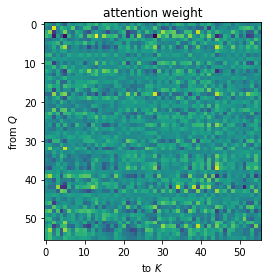

In [148]:
import matplotlib.pyplot as plt

plt.title('attention weight')
plt.imshow(attention_weights[0])
plt.xlabel('to $K$')
plt.ylabel('from $Q$')
plt.show()

### Multi-head Attention

<img src="src/multihead.png" width=800 />

In [186]:
import numpy as np

x   = np.random.randn(   128,  56, 100) # (b,t,n_x) == (b,t,d_k)
W_q = np.random.randn(4,   1, 100,  20) * 0.01
W_k = np.random.randn(4,   1, 100,  20) * 0.01
W_v = np.random.randn(4,   1, 100,   5) * 0.01

            #  h
Q = x @ W_q # (4,128,56,20)
K = x @ W_k # (4,128,56,20)
V = x @ W_v # (4,128,56, 5)

QK_T = Q @ K.transpose(0,1,3,2) # (4,128,56,20) @ (4,128,20,56)
QK_T /= K.shape[-1]**(1/2)

QK_T = np.exp(QK_T)
attention_weights = QK_T / QK_T.sum(-1, keepdims=True) # softmaxed (4,128,56,56)

                          #                 to K
                          #     |        -softmaxed-   --v--       |       | --v'-- |
                          #     |        -softmaxed-   --v--       |       | --v'-- |
                          # 4 * | from Q -softmaxed- @ --v--       | = 4 * | --v'-- |
                          #     |        -softmaxed-   --v--       |       | --v'-- |
                          #     |        -softmaxed-   --v--       |       | --v'-- |
A = attention_weights @ V #            (4,128,56,56) @ (4,128,56,5)
print(f"{A.shape = }")

A = A.transpose(1,2,3,0)
print(f"{A.shape = }")

A = A.reshape(128,56,20) # concat
print(f"{A.shape = }")

A.shape = (4, 128, 56, 5)
A.shape = (128, 56, 5, 4)
A.shape = (128, 56, 20)


### Transformer